# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
bank_survey_full_df = pd.read_csv('/bin/data/bank-additional-full.csv', sep = ';')

In [3]:
bank_survey_full_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# Remove specified columns and create a new DataFrame
# Here a few columns that are not considered to be relevant for our analysis are being dropped.  Such as if the clients were contacted on a specific day of the week
# Addtionally some of the fields had 'unknown' markers are also being removed

bank_survey_df = bank_survey_full_df.drop(columns=['contact', 'month', 'day_of_week', 'duration', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])

# Remove rows with 'unknown' values in 'default', 'housing' and 'loan' columns
bank_survey_df = bank_survey_df[
    (bank_survey_df['default'] != 'unknown') &
    (bank_survey_df['housing'] != 'unknown') &
    (bank_survey_df['loan'] != 'unknown')
]

# Display the head of the new DataFrame to verify the changes
display(bank_survey_df.head())
display(bank_survey_df.info())

,age,job,marital,education,default,housing,loan,campaign,pdays,previous,y
0,56,housemaid,married,basic.4y,no,no,no,1,999,0,no
2,37,services,married,high.school,no,yes,no,1,999,0,no
3,40,admin.,married,basic.6y,no,no,no,1,999,0,no
4,56,services,married,high.school,no,no,yes,1,999,0,no
6,59,admin.,married,professional.course,no,no,no,1,999,0,no


<class 'pandas.core.frame.DataFrame'>
Index: 31828 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31828 non-null  int64 
 1   job        31828 non-null  object
 2   marital    31828 non-null  object
 3   education  31828 non-null  object
 4   default    31828 non-null  object
 5   housing    31828 non-null  object
 6   loan       31828 non-null  object
 7   campaign   31828 non-null  int64 
 8   pdays      31828 non-null  int64 
 9   previous   31828 non-null  int64 
 10  y          31828 non-null  object
dtypes: int64(4), object(7)
memory usage: 2.9+ MB


None

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [ ]:
bank_survey_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31828 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31828 non-null  int64 
 1   job        31828 non-null  object
 2   marital    31828 non-null  object
 3   education  31828 non-null  object
 4   default    31828 non-null  object
 5   housing    31828 non-null  object
 6   loan       31828 non-null  object
 7   campaign   31828 non-null  int64 
 8   pdays      31828 non-null  int64 
 9   previous   31828 non-null  int64 
 10  y          31828 non-null  object
dtypes: int64(4), object(7)
memory usage: 2.9+ MB


In [ ]:
# Based on of few categorical values and numeric values and based on some of the past campain results
# ability to predict if prospective customer will open a CD with the bank
# The idea is to use of the fiels and try to identify a pattern that could emerge to be able to target
# work with high potential customers first and then as time and resources are available work with other customers

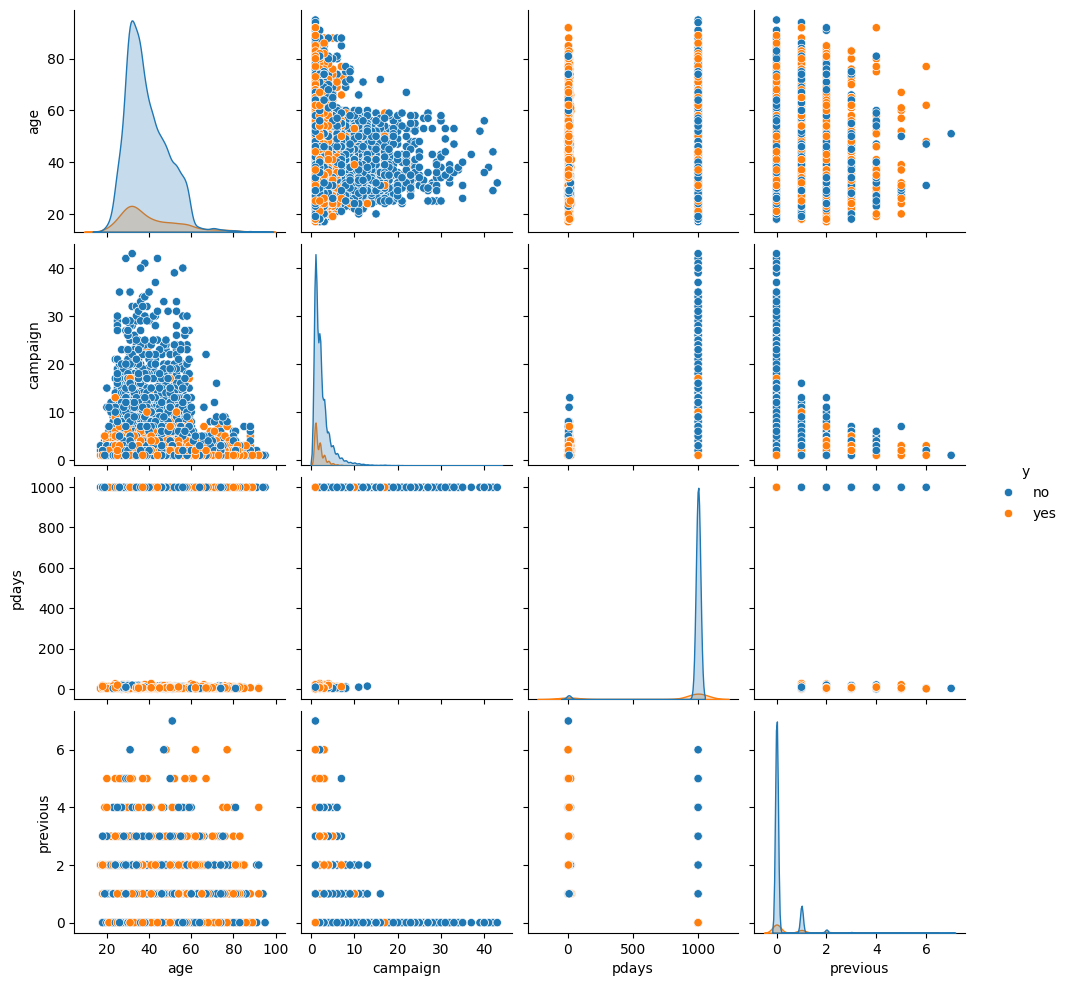

None

In [11]:
# Visualization of data sometimes highlights relations ship between features that may not cear with just the data
# Pairplot of numerical features with 'y' as hue
sns.pairplot(bank_survey_df, vars=numerical_features, hue='y')
display(plt.show())

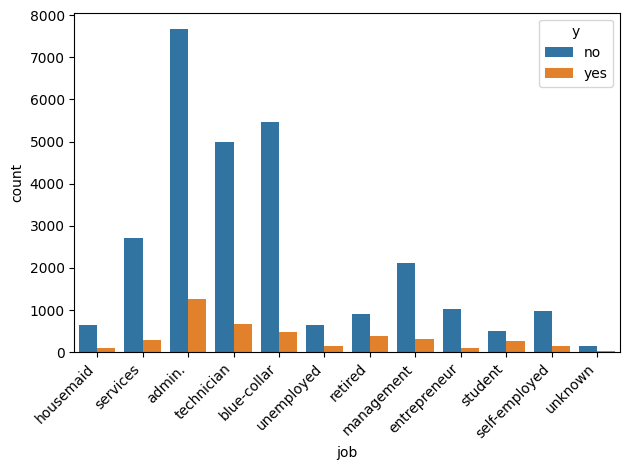

None

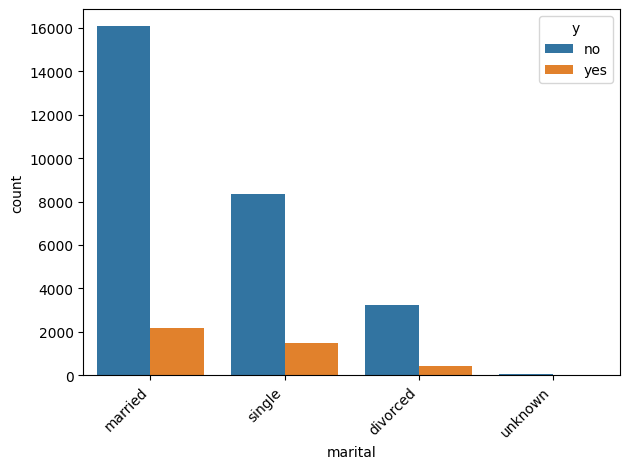

None

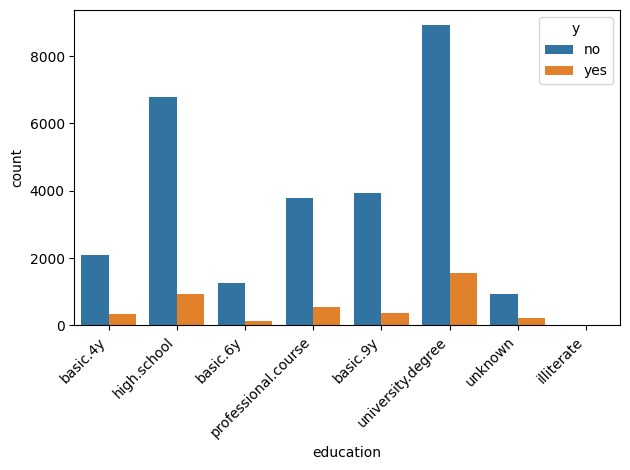

None

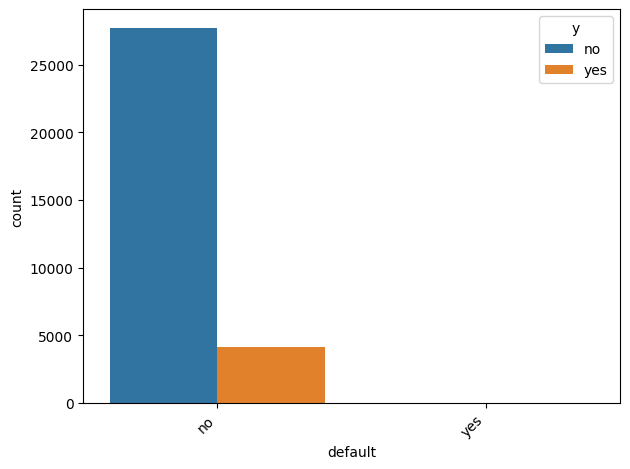

None

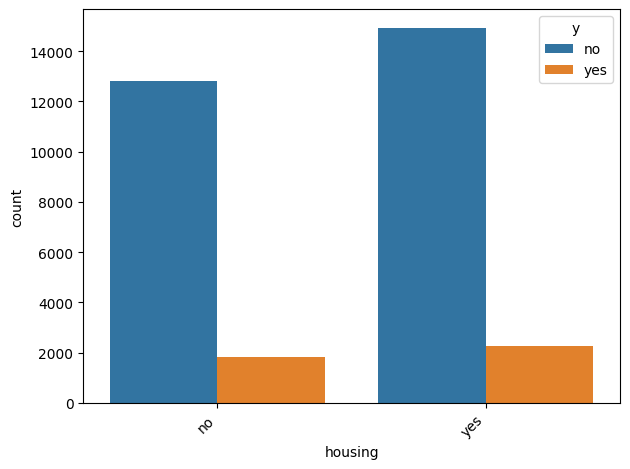

None

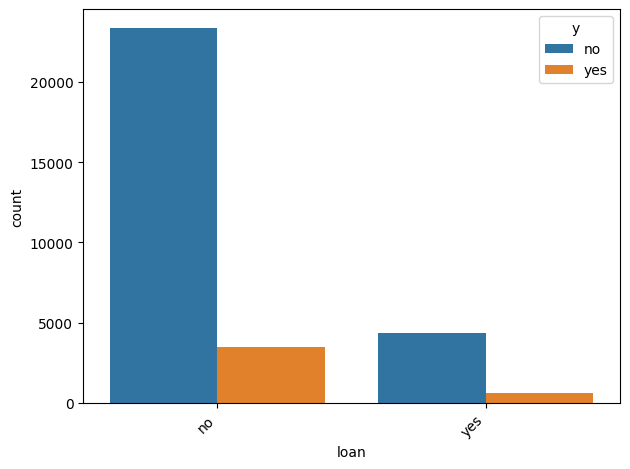

None

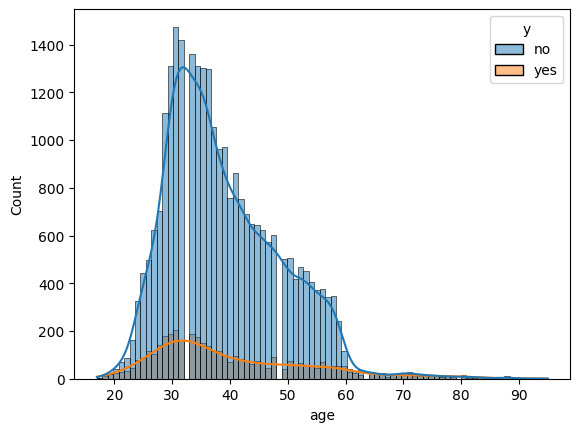

None

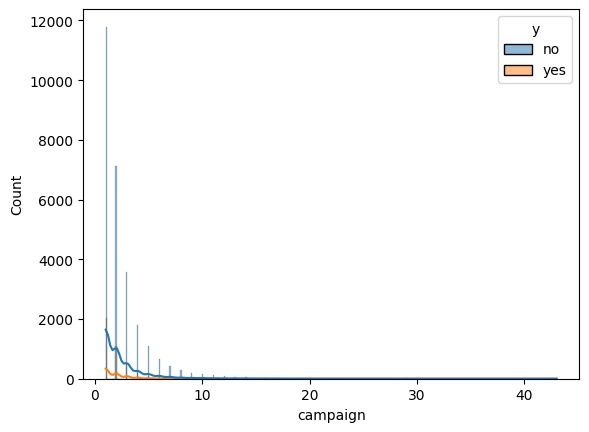

None

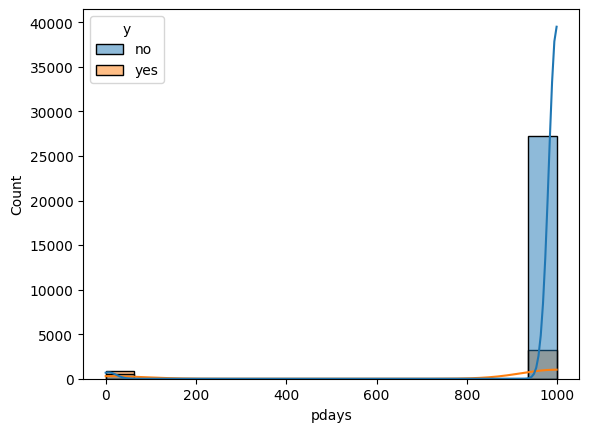

None

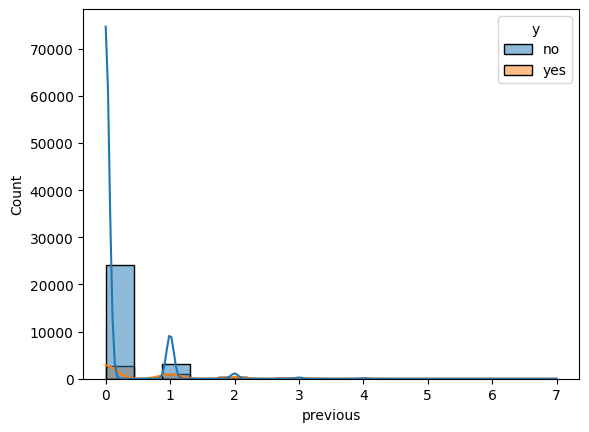

None

In [12]:
# Few plots to evaluate categorical features and numerical features

# Categorical features with 'y' as hue
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']
for feature in categorical_features:
    sns.countplot(data=bank_survey_df, x=feature, hue='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    display(plt.show())

# Numerical features with 'y' as hue
numerical_features = ['age', 'campaign', 'pdays', 'previous']
for feature in numerical_features:
    sns.histplot(data=bank_survey_df, x=feature, hue='y', kde=True)
    display(plt.show())

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [13]:
# Identify categorical features and numerical features
# Use the transformer function to create necessary columns
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']
numerical_features = ['age', 'campaign', 'pdays', 'previous']

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    (StandardScaler(), numerical_features),
    remainder='passthrough' # Keep other columns as is if any
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [14]:
# Create X_train, X_test, y_train, y_test to be able to train and test the various models
X_train, X_test, y_train, y_test = train_test_split(bank_survey_df.drop('y', axis=1), bank_survey_df['y'], test_size=0.2, random_state=42)

print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nTesting set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (25462, 10)
y_train: (25462,)

Testing set shapes:
X_test: (6366, 10)
y_test: (6366,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [15]:
# Create a dummy classifier that predicts for setting a baseline for other model comparison
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
baseline_accuracy = dummy_classifier.score(X_test, y_test)

print(f"Dummy classifier's baseline accuracy is -> {baseline_accuracy:.4f}")

Dummy classifier's baseline accuracy is -> 0.8704


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [16]:
# Create a Logistic Regression model
log_reg_pipeline = Pipeline(steps=[('preprocessor', transformer), ('classifier', LogisticRegression())])
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous'])])),
                ('classifier', LogisticRegression())])

### Problem 9: Score the Model

What is the accuracy of your model?

In [17]:
# Score the Logistic Regression model based on the test data
log_reg_accuracy = log_reg_pipeline.score(X_test, y_test)
print(f"Logistic regression's accuracy is -> {log_reg_accuracy:.4f}")

Logistic regression's accuracy is -> 0.8842


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [18]:
# Initialize models with default parameters
knn_model = KNeighborsClassifier()
decision_tree_model = DecisionTreeClassifier()
svm_model = SVC()

# Create pipelines for each model
knn_pipeline = Pipeline(steps=[('preprocessor', transformer), ('classifier', knn_model)])
decision_tree_pipeline = Pipeline(steps=[('preprocessor', transformer), ('classifier', decision_tree_model)])
svm_pipeline = Pipeline(steps=[('preprocessor', transformer), ('classifier', svm_model)])

# Dictionary to store results
results = {}

# Function to train and evaluate a model
#def train_and_evaluate_model(model_name, pipeline, X_train, y_train, X_test, y_test):
def train_and_evaluate_model(model_name, pipeline):
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time

    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)

    results[model_name] = {
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    }

# Train and evaluate models
train_and_evaluate_model("Logistic Regression", log_reg_pipeline)
train_and_evaluate_model("K Nearest Neighbors", knn_pipeline)
train_and_evaluate_model("Decision Tree", decision_tree_pipeline)
train_and_evaluate_model("SVM", svm_pipeline)

# Create a DataFrame from the results
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results
display(results_df)

,Train Time,Train Accuracy,Test Accuracy
Logistic Regression,0.308680,0.884927,0.884229
K Nearest Neighbors,0.146701,0.891721,0.873233
Decision Tree,0.868490,0.951771,0.832705
SVM,70.965330,0.885948,0.884386


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [35]:
# KNN classification method tuning of hyperparameter number of neighbors
tuned_results = {}
# Create a pipeline and parameters range (number of parameters - 1 for max)
knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier())])
params = {'knn__n_neighbors': list(range(1, 9, 1))}

# Use GridSearchCV for optimizing / tuning; Identify the best parameters
knn_grid = GridSearchCV(knn_pipe, param_grid=params)
start_time = time.time()
knn_grid.fit(X_train, y_train)
best_k = knn_grid.best_params_['knn__n_neighbors']
best_acc = knn_grid.score(X_test, y_test)
end_time = time.time()
train_time = end_time - start_time

tuned_results["K Nearest Neighbors"] = {
        'Train Time': train_time,
        'Accuracy': best_acc,
        'Best hyperparameter': f"Best k: {best_k}"
    }

print(f"Best k: {best_k}")
print(f"Best accuracy on test set: {best_acc}")
print(f"Training time: {train_time:.2f} seconds")

Best k: 8
Best accuracy on test set: 0.8799874332390826
Training time: 302.77 seconds


In [36]:
# Decision tree method tuning of hyperparameter tree max depth

# Create a pipeline and parameters range (number of parameters - 1 for max)
decision_tree_pipe = Pipeline([('transform', transformer), ('tree', DecisionTreeClassifier(random_state=42))])
params = {'tree__max_depth': list(range(1, 21))}

# Use GridSearchCV for optimizing / tuning; Identify the best parameters
tree_grid = GridSearchCV(decision_tree_pipe, param_grid=params, cv=5, scoring='accuracy')
start_time = time.time()
tree_grid.fit(X_train, y_train)
best_depth = tree_grid.best_params_['tree__max_depth']
best_acc = tree_grid.score(X_test, y_test)
end_time = time.time()
train_time = end_time - start_time

tuned_results["Decision Tree"] = {
        'Train Time': train_time,
        'Accuracy': best_acc,
        'Best hyperparameter': f"Decision tree max depth -> {best_depth}"
    }

print(f"Decision tree max depth -> {best_depth}")
print(f"Decision tree accuracy score -> {best_acc:.4f}")
print(f"Training time: {train_time:.2f} seconds")

Decision tree max depth -> 3
Decision tree accuracy score -> 0.8831
Training time: 27.67 seconds


In [38]:
# Logistic gegression method tuning of hyperparameter

# Create a pipeline and parameters range (number of parameters - 1 for max)
log_reg_pipe = Pipeline([('transform', transformer), ('logreg', LogisticRegression(max_iter=1000))])
params = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2']
}

# Use GridSearchCV for optimizing / tuning; Identify the best parameters
log_reg_grid = GridSearchCV(log_reg_pipe, param_grid=params, cv=5, scoring='accuracy')
start_time = time.time()
log_reg_grid.fit(X_train, y_train)
best_params = log_reg_grid.best_params_
best_acc = log_reg_grid.score(X_test, y_test)
end_time = time.time()
train_time = end_time - start_time

tuned_results["Logistic Regression"] = {
        'Train Time': train_time,
        'Accuracy': best_acc,
        'Best hyperparameter': f"Logistic regression best parameters -> {best_params}"
    }

print(f"Logistic regression best parameters -> {best_params}")
print(f"Logistic regression accuracy score -> {best_acc:.4f}")
print(f"Training time: {train_time:.2f} seconds")

Logistic regression best parameters -> {'logreg__C': 1, 'logreg__penalty': 'l2'}
Logistic regression accuracy score -> 0.8842
Training time: 9.01 seconds


In [40]:
# SVM method tuning of hyperparameter

# Create a pipeline and parameters range (number of parameters - 1 for max)
svm_pipe = Pipeline([('transform', transformer), ('svm', SVC())])
params = {
    'svm__C': [0.5, 1, 5],
    'svm__kernel': ['linear', 'rbf']
}

# Use GridSearchCV for optimizing / tuning; Identify the best parameters
svm_grid = GridSearchCV(svm_pipe, param_grid=params, cv=3, scoring='accuracy')
start_time = time.time()
svm_grid.fit(X_train, y_train)
best_params = svm_grid.best_params_
best_acc = svm_grid.score(X_test, y_test)
end_time = time.time()
train_time = end_time - start_time

tuned_results["SVM"] = {
        'Train Time': train_time,
        'Accuracy': best_acc,
        'Best hyperparameter': f"SVM method best parameters -> {best_params}"
    }

print(f"SVM method best parameters -> {best_params}")
print(f"SVM method accuracy score -> {best_acc:.4f}")
print(f"Training time: {train_time:.2f} seconds")

SVM method best parameters -> {'svm__C': 1, 'svm__kernel': 'rbf'}
SVM method accuracy score -> 0.8844
Training time: 1618.10 seconds


In [41]:
tuned_results_df = pd.DataFrame.from_dict(tuned_results, orient='index')
print(tuned_results_df)

                      Train Time  Accuracy  \
K Nearest Neighbors   302.770931  0.879987   
Decision Tree          27.671869  0.883129   
Logistic Regression     9.013140  0.884229   
SVM                  1618.104748  0.884386   

                                                   Best hyperparameter  
K Nearest Neighbors                                          Best k: 8  
Decision Tree                             Decision tree max depth -> 3  
Logistic Regression  Logistic regression best parameters -> {'logre...  
SVM                  SVM method best parameters -> {'svm__C': 1, 's...  


In [ ]:
# Based on the results of the models after tuning
# K nearest neighbors and Dedision tree accuracy slightly increased
# Logistic Regression and SVM accuracy remained pretty much the same
# and based on the accuracy score, the SVM model seem to have the highest score

# Although the model can predict customer who will not open a CD (True positive) at a higher rate
# misclassifying a potential subscriber as a non-subscriber (False Negative) might be detremental, basically loosing potential customer
# Hence models with high accuracy might look good on the surface, but also need to watch for other metrics

# Additionally, as you can see SVM model has better accuracy, but also very resource intensive.
# So, with large campaign survey results the bank or other institutions may want to know how much resources they have to create / tune these models
# As the results indicate, Logistic Regression with similar results might be close enough in terms of accuracy

##### Questions